In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from random import choice
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from skimage.transform import resize
from scipy.stats import norm
import tensorflow as tf
from utils import *
#from tensorflow.contrib import layers

In [2]:
from generator import DataGenerator as gen

# For training (WILL bin steering annos, and WILL normalize throttle)           
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
#from generator import preprocess_normalize_images_bin_annos as process_fn       
#from generator import prepare_batch_images_and_labels_RAND_MIRROR as prep_batch 
                                                                                
# For evaluation (will NOT bin steering annos, and will leave throttle 0-1024)  
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
from generator import preprocess_normalize_images_only as process_fn           
from generator import prepare_batch_images_and_labels_NO_MIRROR as prep_batch

base_dir      = '../data/clr_120_160/'
image_dir     = base_dir + 'images/'
anno_dir      = base_dir + 'annotations/'
test_path  = '../data/evened_test.txt'

raw_test = load_dataset(test_path)
test_gen=gen(batch_size=10, 
             data_set=raw_test[:50],
             image_dir=image_dir,
             anno_dir=anno_dir,
             preprocess_fn=process_fn,
             prepare_batch_fn=prep_batch)

Loading Data: 100%|██████████| 50/50 [00:00<00:00, 800.45it/s]


### Perform Prediction on images using ONLY test data


In [9]:
## MAKE SURE YOU LOAD THE CORRECT MODULE

import base_module as model
from load_frozen import load_graph

# SUPER JANK!!! This should be defined in the model
def prepare_data(generator):
    batch    = generator.get_next_batch()
    images   = batch["images"]
    steering = [ele["steering"] for ele in batch["annotations"]]
    throttle = [ele["throttle"] for ele in batch["annotations"]]
    return images, steering, throttle


test_gen.reset()                                               
t_test = trange(test_gen.steps_per_epoch)                     
t_test.set_description(f": Poop")

root = "/home/jp/Documents/FYP/ml/modular_networks/__z__"
frozen_graph_path  = root+"/frozen.pb"
tensor_lookup_path = root+"/tensor_names.json"
tensor_lookup = json.load(open(tensor_lookup_path, 'r'))

#frozen_graph_path = return_info["frozen_meta"]
#tensor_lookup = json.load(open(return_info["tensor_json"]))

prefix = "model"
graph = load_graph(frozen_graph_path, prefix)
x_tens        = graph.get_tensor_by_name(prefix+"/"+tensor_lookup[model.INPUTS][model.IMAGE_INPUT])
prediction_tens = graph.get_tensor_by_name(prefix+"/"+tensor_lookup[model.OUTPUTS][model.PREDICTION])

with tf.Session(graph=graph) as sess:

    control = {"preds" : [], "annos" : []}
    for step in t_test:                       
        images, _, th_annos = prepare_data(test_gen)
        prediction = sess.run(prediction_tens, feed_dict={x_tens: images})
        control["preds"].extend(prediction)
        control["annos"].extend(th_annos)

: Poop: 100%|██████████| 5/5 [00:00<00:00, 15.86it/s]


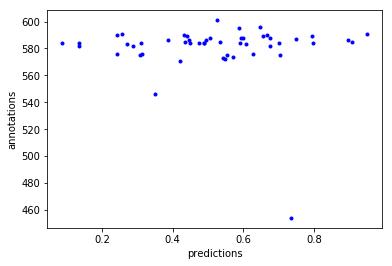

In [10]:
plt.plot(control["preds"], control["annos"], 'b.')
plt.xlabel("predictions")
plt.ylabel("annotations")
fig = plt.gcf()
#fig.savefig('tf_jp_clr_15bins_scatter.png', dpi=100)

# Time Series tracking

Text(0.5,0,'throttle command')

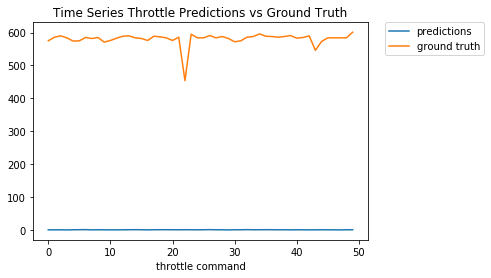

In [11]:
plt.plot(control["preds"], label="predictions")
plt.plot(control["annos"], label="ground truth")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Time Series Throttle Predictions vs Ground Truth")
plt.xlabel("time (frames)")
plt.xlabel("throttle command")